# Feature extraction using VGG16

In [1]:
# tf tools
import tensorflow as tf

# image processsing
from tensorflow.keras.preprocessing.image import (load_img,
                                                  img_to_array,
                                                  ImageDataGenerator)
# VGG16 model
from tensorflow.keras.applications.vgg16 import (preprocess_input,
                                                 decode_predictions,
                                                 VGG16)
# cifar10 data - 32x32
from tensorflow.keras.datasets import cifar10

# layers
from tensorflow.keras.layers import (Flatten, 
                                     Dense, 
                                     Dropout, 
                                     BatchNormalization)
# generic model object
from tensorflow.keras.models import Model

# optimizers
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import SGD

#scikit-learn
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report

# for plotting
import numpy as np
import matplotlib.pyplot as plt

2023-04-14 12:28:40.683158: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Plotting function (from last week)

In [2]:
def plot_history(H, epochs):
    plt.style.use("seaborn-colorblind")

    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.plot(np.arange(0, epochs), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, epochs), H.history["val_loss"], label="val_loss", linestyle=":")
    plt.title("Loss curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.tight_layout()
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(np.arange(0, epochs), H.history["accuracy"], label="train_acc")
    plt.plot(np.arange(0, epochs), H.history["val_accuracy"], label="val_acc", linestyle=":")
    plt.title("Accuracy curve")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.tight_layout()
    plt.legend()
    plt.show()

## Initialize the model

In [3]:
# load the model
model = VGG16() # 500 mb 

553467096/553467096 [==============================] - 12s 0us/step


__Preprocessing__

Keras provides some tools to help with this step.

First, we can use the ```load_img()``` function to load the image and resize it to the required size of 224×224 pixels.

In [4]:
# load an image from file
image = load_img(os.path.join("..", "data", "img", "florence.jpg"), target_size=(224, 224)) # Specifying pixal size of 224 x 244

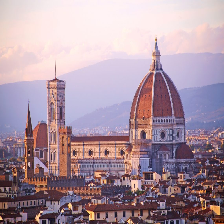

In [5]:
image

Next, we can convert the pixels to a NumPy array so that we can work with it in Keras. 

We can use the ```img_to_array()``` function for this.

In [6]:
# convert the image pixels to a numpy array
image = img_to_array(image)

The network expects one or more images as input; that means the input array will need to be 4-dimensional: samples, rows, columns, and channels.

We only have one sample (one image). We can reshape the array by calling ```reshape()``` and adding the extra dimension.

In [7]:
# reshape data for the model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# 1 object, image-shape 224 width, image-shape 224 height, image-shape 3 (colour channels)

Next, the image pixels need to be prepared in the same way as the ImageNet training data was prepared. Specifically, from the paper:

>The only preprocessing we do is subtracting the mean RGB value, computed on the training set, from each pixel. 

See the paper [here](https://arxiv.org/abs/1409.1556).

In [8]:
# prepare the image for the VGG model
image = preprocess_input(image) # using tensorflow function for preprocessing

## Make prediction using ImageNet labels

We then use the model to predict our image class and convert probabilities to class labels using ```decode_predictions()```.

In [9]:
# predict the probability across all output classes
y_pred = model.predict(image)
# convert the probabilities to class labels
label = decode_predictions(y_pred)

35363/35363 [==============================] - 0s 1us/step


__Inspect most likely label__

In [10]:
label

[[('n03220513', 'dome', 0.45702526),
  ('n03028079', 'church', 0.301825),
  ('n03877845', 'palace', 0.04829808),
  ('n02930766', 'cab', 0.026109034),
  ('n02825657', 'bell_cote', 0.024095427)]]

## Finetune on new task

We import the regular cifar10 dataset from ```keras``` and normalise.

In [11]:
((X_train, y_train), (X_test, y_test)) = cifar10.load_data() # Loading cifar 10
X_train = X_train.astype("float") / 255.
X_test = X_test.astype("float") / 255.

170498071/170498071 [==============================] - 7s 0us/step


__Binarize labels__

In [12]:
# integers to one-hot vectors
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.fit_transform(y_test)

# initialize label names for CIFAR-10 dataset
labelNames = ["airplane", "automobile", 
              "bird", "cat", 
              "deer", "dog", 
              "frog", "horse", 
              "ship", "truck"]

__Check tensor shape__

In [13]:
X_train.shape # (5000, 32, 32, 3)

(50000, 32, 32, 3)

__Load VGG16 *without* the classification layers__

Here we're just loading the convolutional layers and not the final classification network, using the argument ```include_top=False```

We also redefine the input shape, to work better with our cifar10 data.

In [14]:
# load model without classifier layers
model = VGG16(include_top=False, # Removes the classification layer 
              pooling='avg', # Creating an average pool instead of a classification layer 
              input_shape=(32, 32, 3)) # Change input layer to 32 instead of 224

58889256/58889256 [==============================] - 2s 0us/step


__Disable training of Conv layers__

We need to disable the convolutional layers before training. Why?

In [15]:
# mark loaded layers as not trainable
for layer in model.layers: # For each layer in the model set trainable to false. 
    layer.trainable = False # Tell it not to update the prevoiously trained weights from VVG16

In [16]:
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

__Add new classification layers__

We now add new classification layers after the convolutional layers.

Notice how here we are not using the ```Sequential```, so we have to explicitly name the preceding layer in the model!

In [17]:
tf.keras.backend.clear_session() 

In [18]:
# add new classifier layers
flat1 = Flatten()(model.layers[-1].output) # Flatten() = flattens the data, followed by the old layer that came before
class1 = Dense(128, activation='relu')(flat1) # first classifation layer, New layer dense, preivous layer flat1
output = Dense(10, activation='softmax')(class1) # prediction layer

# define new model
model = Model(inputs=model.inputs, 
              outputs=output)
# summarize
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

__Compile__

We're going to be using a more sophisticated optimization algorithm, which you can read about [here](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/ExponentialDecay).

In [19]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01, # Start with this learning rate, but over time learn slower and slowe . 
    decay_steps=10000, # Every 10 000 steps, reduce learning rate. 
    decay_rate=0.9) # Reduce / decay by 0.9 // exponatial. so we decay by 0.01^ 0.9. decay by 0.01 to the power of 0.9
sgd = SGD(learning_rate=lr_schedule)# SDG class from tensorflow. 
# sdg was previously called optimizer. 

In [20]:
model.compile(optimizer=sgd,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

__Train__

In [21]:
H = model.fit(X_train, y_train, 
            validation_split=0.1,
            batch_size=128,
            epochs=10,
            verbose=1)

Epoch 1/10
352/352 [==============================] - 229s 648ms/step - loss: 2.0672 - accuracy: 0.2756 - val_loss: 1.8524 - val_accuracy: 0.3826
Epoch 2/10
352/352 [==============================] - 225s 639ms/step - loss: 1.7613 - accuracy: 0.4048 - val_loss: 1.6533 - val_accuracy: 0.4480
Epoch 3/10
352/352 [==============================] - 224s 636ms/step - loss: 1.6216 - accuracy: 0.4502 - val_loss: 1.5563 - val_accuracy: 0.4770
Epoch 4/10
352/352 [==============================] - 223s 634ms/step - loss: 1.5416 - accuracy: 0.4706 - val_loss: 1.4897 - val_accuracy: 0.4860
Epoch 5/10
352/352 [==============================] - 225s 640ms/step - loss: 1.4894 - accuracy: 0.4870 - val_loss: 1.4512 - val_accuracy: 0.5008
Epoch 6/10
352/352 [==============================] - 223s 635ms/step - loss: 1.4523 - accuracy: 0.4995 - val_loss: 1.4155 - val_accuracy: 0.5102
Epoch 7/10
352/352 [==============================] - 224s 635ms/step - loss: 1.4228 - accuracy: 0.5086 - val_loss: 1.3977 -

__Evaluate__

/tmp/ipykernel_1279/3716877966.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-colorblind")


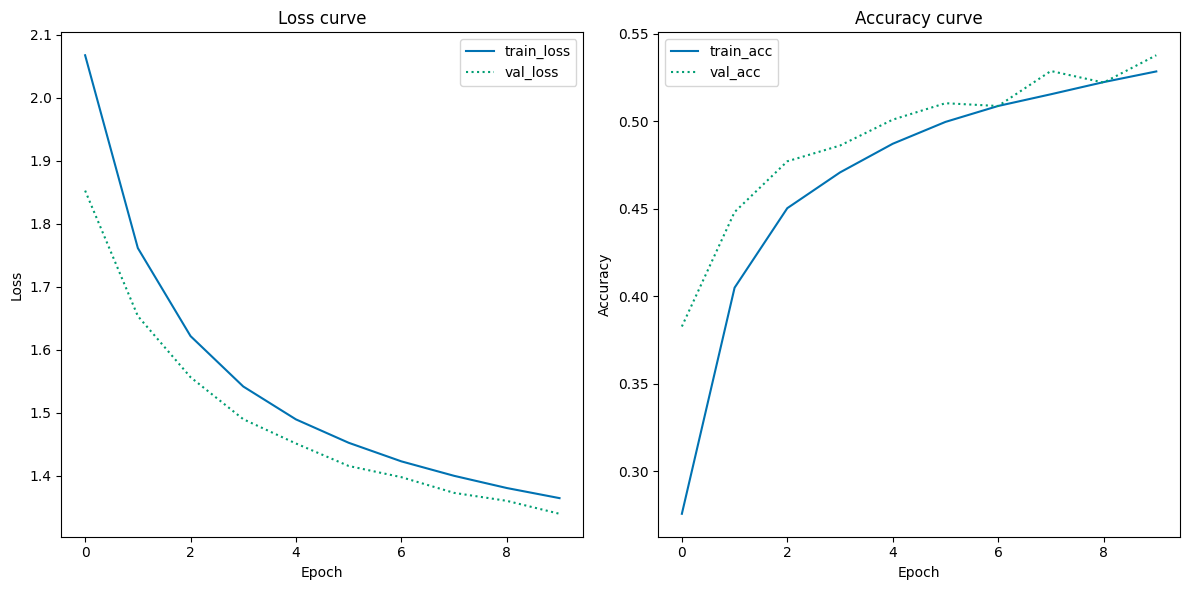

In [22]:
plot_history(H, 10)

In [23]:
predictions = model.predict(X_test, batch_size=128)
print(classification_report(y_test.argmax(axis=1),
                            predictions.argmax(axis=1),
                            target_names=labelNames))

79/79 [==============================] - 45s 567ms/step
              precision    recall  f1-score   support

    airplane       0.58      0.59      0.59      1000
  automobile       0.52      0.60      0.55      1000
        bird       0.52      0.29      0.37      1000
         cat       0.34      0.49      0.40      1000
        deer       0.53      0.49      0.51      1000
         dog       0.50      0.44      0.47      1000
        frog       0.59      0.61      0.60      1000
       horse       0.59      0.53      0.56      1000
        ship       0.62      0.64      0.63      1000
       truck       0.51      0.54      0.52      1000

    accuracy                           0.52     10000
   macro avg       0.53      0.52      0.52     10000
weighted avg       0.53      0.52      0.52     10000



## Using data augmentation

__Reload model__

In [24]:
del model
tf.keras.backend.clear_session()

In [25]:
# load model without classifier layers
model = VGG16(include_top=False, 
              pooling='avg',
              input_shape=(32, 32, 3))

# mark loaded layers as not trainable
for layer in model.layers:
    layer.trainable = False
    
# add new classifier layers
flat1 = Flatten()(model.layers[-1].output)
bn = BatchNormalization()(flat1) # Added batnormalization from tensorflow. Take the previouslayer, normalise the values, and than pass them on
class1 = Dense(256, 
               activation='relu')(bn) # Added new classification layer 
class2 = Dense(128, 
               activation='relu')(class1)
output = Dense(10, 
               activation='softmax')(class2)

# define new model
model = Model(inputs=model.inputs, 
              outputs=output)

# compile
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=10000,
    decay_rate=0.9)
sgd = SGD(learning_rate=lr_schedule)

model.compile(optimizer=sgd,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
# summarize
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

__Define data generator__

You can see the documentation for ImageDataGenerator [here](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)

In [26]:
# flip along x axis (mirror image)
# Data augmentaion 
# ImageDataGenerator from tensorflow 
datagen = ImageDataGenerator(horizontal_flip=True, # Flip it horizontally around the access
                             rotation_range=20, # Rotate the image randomly 20 degress around the access
                             validation_split = 0.1) # Take 10 % for validation
# Take your images, create a pipelie (Take an image modify it, pass it on)


We're choosing to generate data on the fly, rather than save it to a folder.

__Train__

In [35]:
# fit the data generator to our images
datagen.fit(X_train) # Fit the training data to our data augmentation 
# fits the model on batches with real-time data augmentation:
H = model.fit(datagen.flow(X_train, y_train, batch_size=128, subset = "training"), # Creating a flow -- take the original images, some get modifyied. 
              validation_data = datagen.flow(X_train, y_train, batch_size=128, subset = "validation"),
            epochs=10) # change to 10


# Possible to get image (stream the image) (stream it frow the dataGenerator) from the folder, instead of loading the image into the script. 

Epoch 1/10


2023-04-14 13:50:58.708105: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


352/352 [==============================] - ETA: 0s - loss: 1.3035 - accuracy: 0.5442

2023-04-14 13:53:42.915462: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


352/352 [==============================] - 187s 531ms/step - loss: 1.3035 - accuracy: 0.5442 - val_loss: 1.2678 - val_accuracy: 0.5594
Epoch 2/10
352/352 [==============================] - 227s 645ms/step - loss: 1.2825 - accuracy: 0.5517 - val_loss: 1.2658 - val_accuracy: 0.5588
Epoch 3/10
352/352 [==============================] - 228s 647ms/step - loss: 1.2639 - accuracy: 0.5583 - val_loss: 1.2427 - val_accuracy: 0.5580
Epoch 4/10
352/352 [==============================] - 227s 646ms/step - loss: 1.2485 - accuracy: 0.5621 - val_loss: 1.2389 - val_accuracy: 0.5756
Epoch 5/10
352/352 [==============================] - 228s 647ms/step - loss: 1.2347 - accuracy: 0.5687 - val_loss: 1.2400 - val_accuracy: 0.5636
Epoch 6/10
352/352 [==============================] - 227s 644ms/step - loss: 1.2183 - accuracy: 0.5712 - val_loss: 1.2253 - val_accuracy: 0.5666
Epoch 7/10
 27/352 [=>............................] - ETA: 3:09 - loss: 1.2059 - accuracy: 0.5877

KeyboardInterrupt: 

__Inspect__

/tmp/ipykernel_1279/3716877966.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-colorblind")


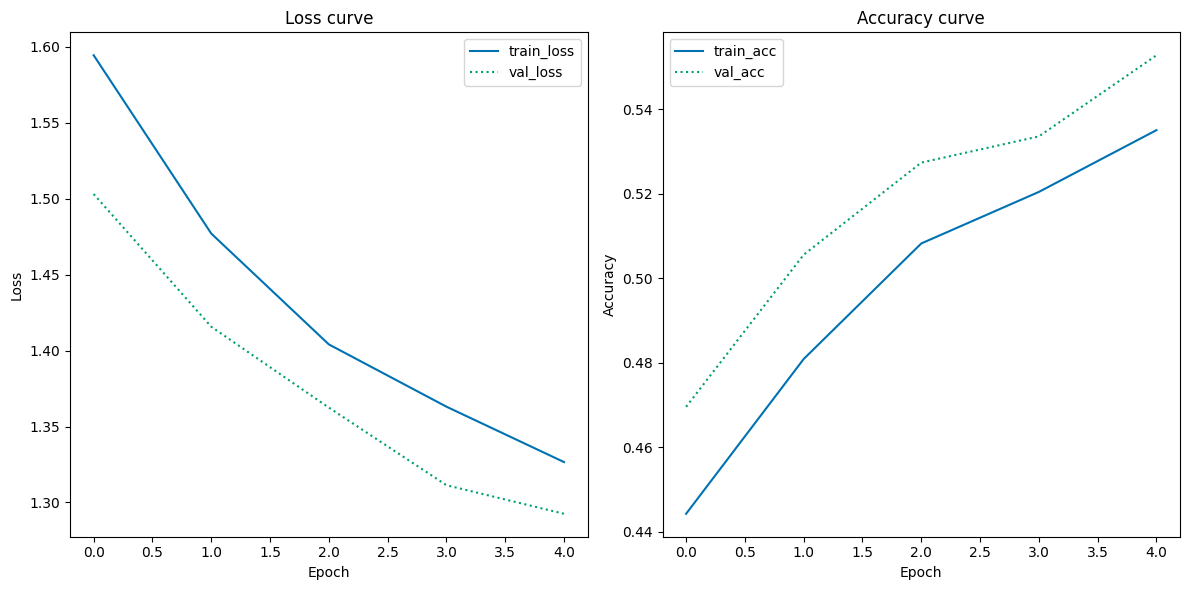

In [32]:
plot_history(H, 5) # Change to 10

__Evaluate__

In [34]:
predictions = model.predict(X_test, batch_size=128)
print(classification_report(y_test.argmax(axis=1),
                            predictions.argmax(axis=1),
                            target_names=labelNames))

79/79 [==============================] - 33s 418ms/step
              precision    recall  f1-score   support

    airplane       0.57      0.67      0.62      1000
  automobile       0.57      0.61      0.59      1000
        bird       0.53      0.37      0.43      1000
         cat       0.40      0.34      0.37      1000
        deer       0.53      0.47      0.50      1000
         dog       0.51      0.48      0.50      1000
        frog       0.53      0.67      0.59      1000
       horse       0.58      0.61      0.60      1000
        ship       0.66      0.61      0.63      1000
       truck       0.51      0.58      0.54      1000

    accuracy                           0.54     10000
   macro avg       0.54      0.54      0.54     10000
weighted avg       0.54      0.54      0.54     10000

